Telco Customer Churn Prediction Project

## 1. Veri Yükleme ve Ön İnceleme (EDA)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import seaborn as sns

df = pd.read_csv("../data/data.csv")


## Veri Ön İşleme (Preprocessing)  

In [2]:
df['TotalCharges'] = df['TotalCharges'].replace(" ", np.nan)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())


In [3]:
df['Churn'].value_counts(normalize=True)

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

Elimizde Soyle Bir Tablo Var:  
-%73 Mutlu Müşteri (No): Kalmışlar.  
-%26 Küskün Müşteri (Yes): Gitmişler.  
-Bizim burada yapmamız gereken şeylerden en önemlisi modelimizi eğitirken doğruluk oranımızın /73 üstü olması gerekiyor.  
->Çünkü biz hiçbir şey yapmasak model  Yes / No dese %73 tutturacak zaten.  

In [4]:
df.drop('customerID', axis=1,inplace=True)


In [5]:
df.groupby('gender')['Churn'].value_counts(normalize=True)


gender  Churn
Female  No       0.730791
        Yes      0.269209
Male    No       0.738397
        Yes      0.261603
Name: proportion, dtype: float64

Özellikleri seçerken cinsiyet faktörü etkiler mi etkilemez mi diye düşünücek olursak bir üst  tabloya bakarak karar verebilirsiniz.

In [6]:
df.drop('gender',axis=1,inplace=True)


In [7]:
df.groupby('Churn')[['tenure','MonthlyCharges']].mean(numeric_only=True)


,tenure,MonthlyCharges
Churn,,
No,37.569965,61.265124
Yes,17.979133,74.441332


Gidenlerin faturası, kalanlara göre %20 daha pahalı.

In [8]:
df.groupby('Churn')['Contract'].value_counts(normalize=True)

Churn  Contract      
No     Month-to-month    0.429068
       Two year          0.318322
       One year          0.252609
Yes    Month-to-month    0.885500
       One year          0.088818
       Two year          0.025682
Name: proportion, dtype: float64

Gidenlerin (Yes) %88'i "Month-to-month" (Taahhütsüz) sözleşme kullanıyormuş.  
Gidenlerin sadece %2'si "Two year" (2 Yıllık) sözleşmeliymiş.  

->Modelimizi geliştirme aşamasına geçmeden önce şu analizi iyi yapmış olmamız gerekiyor..  
1.Yeni Gelmiş Olması  
2.Faturaları yüksek gelmiş  
3.Taahhütsüz olması  
Bizim şirketimizden müşterinin gitmesine neden olan sebeblerdir.  


In [9]:
df_encoded = df.replace({"Yes":1,"No":0}) #Verileri Bilgisayarın Anlayacağı Hale Getirdik.


In [10]:
df_encoded = pd.get_dummies (df_encoded, drop_first=True)  #One-Hot Encoding -->drop_first=True gereksiz olan sütünü atıcaktır 3 sütün yerine  2 sutunla idare edicektir.  

In [11]:
y = df_encoded['Churn_1']
X = df_encoded.drop('Churn_1',axis=1)

In [12]:
from sklearn.model_selection import train_test_split
X_train , X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

## 1. Model:  LogisticRegression
  **Not: Veriyi önce ham haliyle (Scaling olmadan) modele sokup, başarısızlığı göreceğiz. Ardından Standartlaştırma (Scaling) yapıp farkı inceleyeceğiz.**  

In [13]:

from sklearn.linear_model import LogisticRegression
log_R = LogisticRegression(max_iter=5000,class_weight='balanced') #Modeli cezalandırma ->'balanced'
log_R.fit(X_train,y_train)
y_pred = log_R.predict(X_test)


0.7501774308019872
[[748 288]
 [ 64 309]]


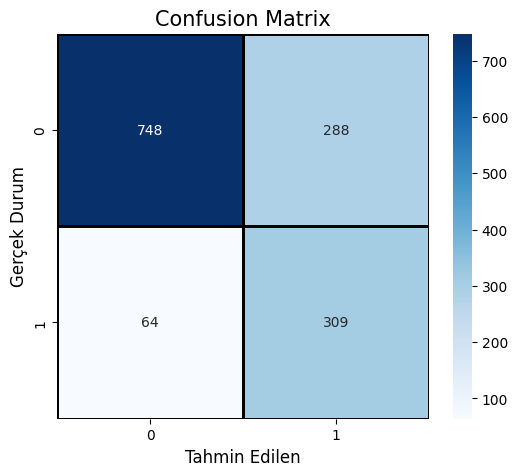

In [14]:
from sklearn.metrics import accuracy_score
accuracy= accuracy_score(y_test,y_pred)
print(accuracy)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix (y_test,y_pred)
print(cm)


plt.figure(figsize=(6, 5)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='black') 
plt.title('Confusion Matrix', fontsize=15)
plt.ylabel('Gerçek Durum', fontsize=12)
plt.xlabel('Tahmin Edilen', fontsize=12)
plt.show()


**Doğru Bildiklerimiz :**
    * **747 Kişi :** Model "Bu müşteri sadık, gitmez" dedi ve gerçekten de gitmediler.  
    * **310 Kişi :** Model "Bu müşteri gidici, dikkat!" dedi ve gerçekten de bu kişiler churn (terk) etti. **(Başarımız burada saklı!)**  

2.**Yanıldıklarımız:**  
    * **289 Kişi :** Model bu kişilere "Gidecek" dedi ama gitmediler.  
        * *İş Yorumu:* Bu kişilere boşuna indirim teklif edebiliriz, şirket biraz maliyet kaybeder ama müşteri kaybetmez.  
    * **63 Kişi :** Model bu kişilere "Gitmez, rahat ol" dedi ama müşteriler sessizce gitti.  
        * *İş Yorumu:* En tehlikeli hatamız bu. Ama sayıca az (63 kişi), bu da modelin "(Recall)" konusunda gayet iyi olduğunu gösterir.  
        
**SONUÇ:** Toplam 373 giden müşterinin (310 + 63), **310 tanesini (%83)** başarıyla tespit ettik! 

Görev : Özelliklerin sayısal değerlerini 0-1 arasında sıkıştırmak.
Amaç : Model yanılgıya düşmesin.

In [15]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


## 2. Model: StandardScaler Haliyle LogisticRegression

0.7494677075940384
[[748 288]
 [ 65 308]]


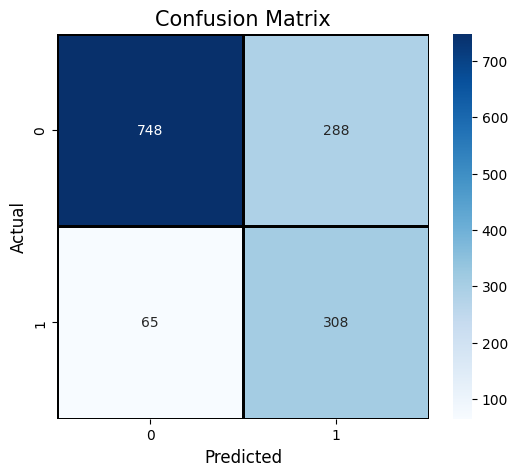

In [16]:
log_R = LogisticRegression(max_iter=3000,class_weight='balanced')
log_R.fit(X_train,y_train)
y_pred = log_R.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
cm = confusion_matrix(y_test,y_pred)
print(accuracy)
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='black') 
plt.title('Confusion Matrix', fontsize=15)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.show()




->Fazladan  +85 Kişiyi Gördü ve Yakaladi.  
->Kaçanlar Azaldı Eskiden 151  idi şimdi 65.  
->a12'da biraz sorun oluştu model o kadar dedektif oldu ki gitmeyene de gidicek gözüyle baktı.  

Şimdi burda duralım bizim baseline'dan ne farkımız var!    
->Burda önemli olan düşünce baseline tahmin yaparken %50 %50 tahmin yapar ve böyle olursa da şirketten kaça müşteri tahmini = 0 olur.  
->Bu durumda bizim hiçbir işimize yaramaz.  
->Bizim modelimiz 308 tane kaçan veya kaçıcak olan müşteri yakaladı başarı oranımız %74.8.  
->Şirket çalışanı olarak düşünücek olursak 308 kişiye %10-%20 arasında bir indirim uygulayarak şirketimize müşteriyi tekrar kazandırabiliriz.  
Tabloyu incelemek isteyenler aşağıdaki tabloya iyice bakabilir.

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.92      0.72      0.81      1036
        True       0.52      0.83      0.64       373

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.75      0.76      1409



**"recall" -> True değerine bakalım 100 müşteriden 83 ünü doğru tahmin ettik.**
StandardScaller = %83 karar oranında verir.  
Baseline Model  = %0 karar oranında  verir.  

## Bakalım sözleşmesini iptal edip gidenler neden gitti?  

En yüksek 'POZİTİF' özellik ->Sözleşmesine son vericek sebebdir.
En düşük  'NEGATİF' özellik->Bizim şirketimizle devam etmek isteyeceklerin sebebidir.

In [18]:
pd.Series(data=log_R.coef_[0],index=X.columns).sort_values()

tenure                                  -1.234045
MonthlyCharges                          -0.854469
Contract_Two year                       -0.651307
InternetService_DSL                     -0.291387
Contract_One year                       -0.282691
StreamingTV_No internet service         -0.143767
OnlineBackup_No internet service        -0.143767
OnlineSecurity_No internet service      -0.143767
DeviceProtection_No internet service    -0.143767
StreamingMovies_No internet service     -0.143767
TechSupport_No internet service         -0.143767
OnlineSecurity_1                        -0.132170
TechSupport_1                           -0.092013
Dependents_1                            -0.069748
PaymentMethod_Credit card (automatic)   -0.026515
OnlineBackup_1                          -0.018943
PaymentMethod_Mailed check              -0.014641
PhoneService_1                          -0.002495
MultipleLines_No phone service           0.002495
Partner_1                                0.018077


-->'TotalCharges' özelliğimiz arttıkça müşterinin  sözleşmesini iptal ettiğini görebiliyoruz.  
-->'Tenure' ise şirkete en sadık olan insanlardır.


Aşağıdak kod grubumuza bakıcak olursak RassalAğaçlar Sınıflandırması kullanılmıştır.    
Başarı oranımızı kıyaslicak olursanız LogReg Sınıflandırmasına göre daha başarısız olduğunu görücek olursunuz.  


0.7977288857345636
[[947  89]
 [196 177]]


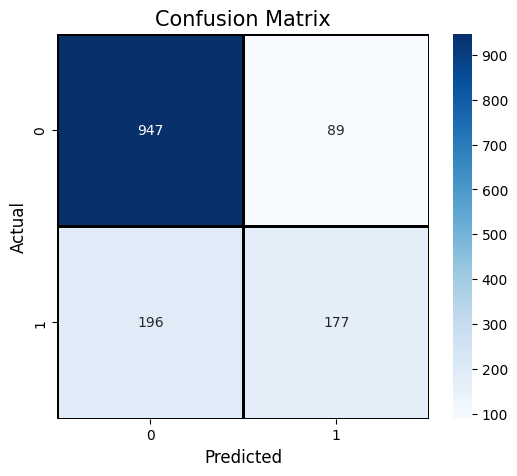

In [19]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
cm = confusion_matrix(y_test,y_pred)
print(accuracy)
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='black') 
plt.title('Confusion Matrix', fontsize=15)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.show()



## 3. Model: Kısıtlandırılmış RandomForestClassifier

0.7743080198722498
[[822 214]
 [104 269]]


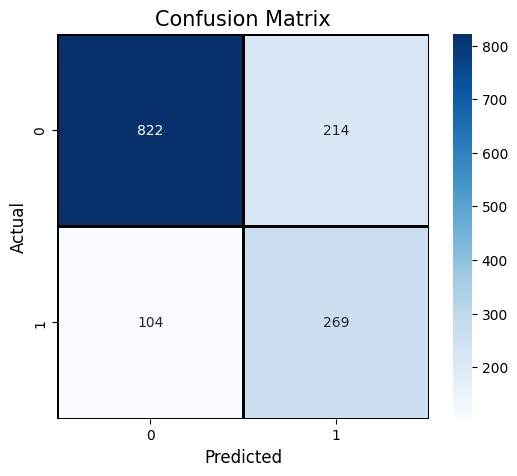

In [20]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_train,y_train)
y_olasiliklar = rfc.predict_proba(X_test)
yeni_tahmin = (y_olasiliklar[:, 1] > 0.30)
accuracy = accuracy_score(y_test,yeni_tahmin)
cm = confusion_matrix(y_test,yeni_tahmin)
print(accuracy)
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='black',cbar=True) 
plt.title('Confusion Matrix', fontsize=15)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.show()

!!815 sadık müşteri tahmin etti.  
->2.satır 1.sütüna bakıcak olursanız yaklaşık 100 kişiyi şirketimize geri kazandırabiliriz.   
->1.satır 2.sütüna bakıcak olursanız da    
!!Yaklaşık 130 tane masum müşteriye de "Sen gideceksin galiba" dedi.  
Şirket için için sorun değil %10 luk indirim tanımladık .Her ihtimalle kısıtlanmamış RandomForest'dan daha iyidir.    

## 4. Model: KNN

0.7643718949609652
[[885 151]
 [181 192]]


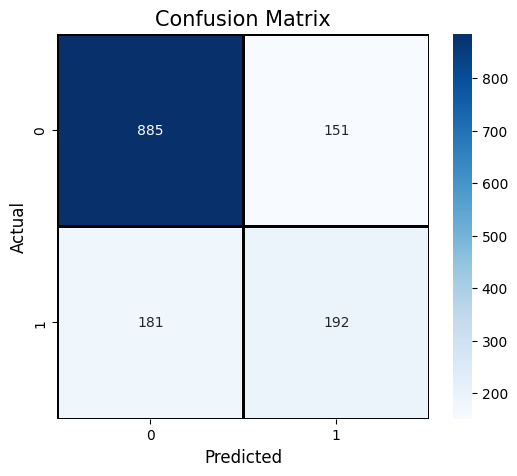

In [21]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
cm = confusion_matrix(y_test,y_pred)
print(accuracy)
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='black') 
plt.title('Confusion Matrix', fontsize=15)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.show()

## Şu ana kadar hangisi daha iyiydi?
KNN algoritması çalışmış ama sonuçlar Random Forest'ın gerisinde kaldı.    
Bu durumda halen en iyi sınıflandırma çeşidimiz -->>LogisticRegression  
Gidenleri yakalama konusunda (Recall) Logistic Regression liderliğini koruyor.  


## 5. Model: Gradient Boosting (XGBoost)

0.8090844570617459
[[941  95]
 [174 199]]


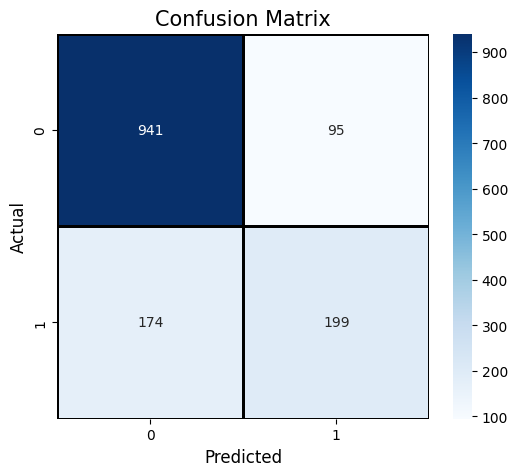

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
gs = GradientBoostingClassifier()
gs.fit(X_train,y_train)
y_pred = gs.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
cm = confusion_matrix(y_test,y_pred)
print(accuracy)
print(cm)


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='black') 
plt.title('Confusion Matrix', fontsize=15)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.show()

Güncel Accuracy: 0.8112136266855926
Confusion Matrix:
[[942  94]
 [172 201]]
 

**En verimli Sonuçları XGBoost Verdiği Için Yolumuza Onunla Devam Ediyoruz.**

Tenure ile SeniorCitizen arasında bir ilişki olabiliceğini varsayalım  
ozel_df['Yasli_Kidem_Etkisi'] = ((ozel_df['tenure'] / 12) + ozel_df['SeniorCitizen']).astype(float)  ile  
Test edelim test ettikten sonra güncel raporu 


Güncel Accuracy: 0.8062455642299503
Confusion Matrix:
[[937  99]
 [174 199]]


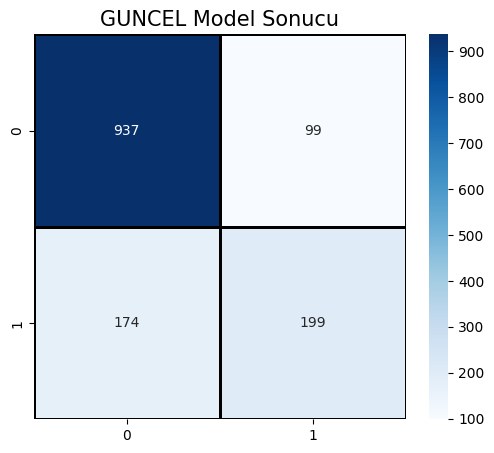

In [23]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
xgboost_df = df_encoded.copy()



bool_cols = xgboost_df.select_dtypes(include=['bool']).columns
xgboost_df[bool_cols] = xgboost_df[bool_cols].astype(int)
xgboost_df['Yasli_Kidem_Etkisi'] = ((xgboost_df['tenure'] / 12) + xgboost_df['SeniorCitizen']).astype(float)

X = xgboost_df.drop('Churn_1', axis=1) 
y = xgboost_df['Churn_1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


xgs = GradientBoostingClassifier(random_state=42)
xgs.fit(X_train, y_train)


y_pred = xgs.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\nGüncel Accuracy: {acc}")
print(f"Confusion Matrix:\n{cm}")


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='black')
plt.title('GUNCEL Model Sonucu', fontsize=15)
plt.show()

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


Ozel_XGboost_df = xgboost_df.copy()
Ozel_XGboost_df['Partner_Film'] = Ozel_XGboost_df['Partner_1'] + Ozel_XGboost_df['StreamingMovies_1']
X = Ozel_XGboost_df.drop('Churn_1', axis=1) 
y = Ozel_XGboost_df['Churn_1']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.22,random_state=42)

gs = GradientBoostingClassifier()
gs.fit(X_train,y_train)
y_pred = gs.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\nGüncel Accuracy: {acc}")
print(f"Confusion Matrix:\n{cm}")


Güncel Accuracy: 0.8058064516129032
Confusion Matrix:
[[1025  108]
 [ 193  224]]


Deneme-yanılma yaklaşımıyla modele eklenen ikinci özelliğin etkisi analiz edilmiştir. Yapılan deneyler, söz konusu özelliğin modele anlamlı bir katkı sağlamadığını ve performansı olumsuz etkilediğini göstermiştir. Bu bulgular doğrultusunda özellik modelden çıkarılmıştır.

# GridSearchCV


In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


GridS_df = Ozel_XGboost_df.copy()
X = GridS_df.drop('Churn_1', axis=1) 
y = GridS_df['Churn_1']

parametreler = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(
    estimator= GradientBoostingClassifier(),
    scoring = 'f1',
    n_jobs = -1,
    param_grid = parametreler
)

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\nGüncel Accuracy: {acc}")
print(f"Confusion Matrix:\n{cm}")



Güncel Accuracy: 0.8070967741935484
Confusion Matrix:
[[1026  107]
 [ 192  225]]


In [26]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


X = GridS_df.drop('Churn_1', axis=1)
y = GridS_df['Churn_1']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ratio = float(y_train.value_counts()[0]) / y_train.value_counts()[1]
model = XGBClassifier(
    scale_pos_weight=ratio,  
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\nGüncel Accuracy: {acc}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Güncel Accuracy: 0.7579843860894251
Confusion Matrix:
 [[757 279]
 [ 62 311]]


In [27]:
data = [
    {"Model": "Logistic Regression",  "Accuracy": 75.01, "Recall": 63.0},
    {"Model": "Scaled LogReg",        "Accuracy": 74.80, "Recall": 65.0},
    {"Model": "Random Forest",        "Accuracy": 79.27, "Recall": 47.0},
    {"Model": "KNN Classifier",       "Accuracy": 76.43, "Recall": 43.0}, 
    {"Model": "Classic XGBoost",      "Accuracy": 80.50, "Recall": 46.0}, 
    {"Model": "GridSearch XGBoost",   "Accuracy": 80.90, "Recall": 46.0}, 
    {"Model": "Özel (Weighted) XGB",  "Accuracy": 75.00, "Recall": 82.5}  
]
df_sonuc = pd.DataFrame(data)

df_sonuc = df_sonuc.sort_values(by="Recall", ascending=False).reset_index(drop=True)

print("   🏆 MODEL KARŞILAŞTIRMA TABLOSU 🏆  ")
print("-" * 40)
print(df_sonuc)


   🏆 MODEL KARŞILAŞTIRMA TABLOSU 🏆  
----------------------------------------
                 Model  Accuracy  Recall
0  Özel (Weighted) XGB     75.00    82.5
1        Scaled LogReg     74.80    65.0
2  Logistic Regression     75.01    63.0
3        Random Forest     79.27    47.0
4      Classic XGBoost     80.50    46.0
5   GridSearch XGBoost     80.90    46.0
6       KNN Classifier     76.43    43.0


## Veri Kümemiz İçin En Doğru Model Seçimi Ekstra Özellik Ekledigimiz  -- > Özel (Weighted) XGB